Link [Colab notebook](https://colab.research.google.com/drive/1t3yim3HJDGdh71NkknVQvvq6wpXp7Nz6?usp=sharing).
# Hard margin SVM

In its most primitive form, Support Vector Machine (SVM) is a linear classification model that solves the binary classification problem. However, unlike other binary classification algorithms such as Perceptron or Logistic regression, SVM requires the decision boundary that seperate the two class regions to maximise the width of the gap between the two categories. 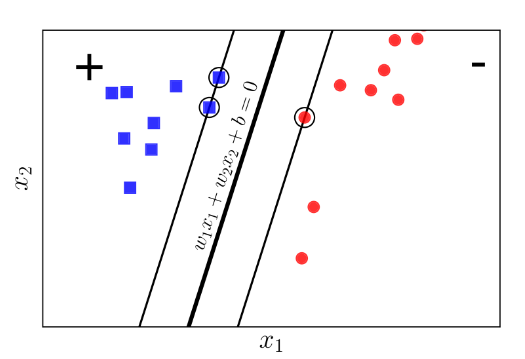

We denote the linear weight (hyperplane) of SVM as a vector $w \in \mathbb R^d$ and $b$ the bias coefficient (this differs from other linear models where the bias term is subsumed into the vector $w$), any point $x$ falls onto this plane would satisfies $\langle w, x \rangle + b = 0$, the data matrix $X \in \mathbb R^{n \times d}$ with $n$ data samples, each has $d$ dimensions, the $i^{th}$ samples in the dataset is $x_i$, the label vector $y \in \mathbb R ^ n$ is a vector denote the class of each datapoint, $y_i \in \{-1, 1\}$. First assuming that the data is linearly seperable, i.e. there exists a hyperplane that perfectly seperates the two classes, this setting is called hard-margin SVM.

A critical operation in SVM is to find the margin, which is basically finding the distance from some point $x$ to the hyperplane $p$ characterized by $(w, b)$. The distance of a point to a plane is the minimum of distance from one point in that plane to the point, i.e.
$$\text{distance from }x\text{ to plane }p = \min_v\{\|x-v\|^2 | \langle w, v \rangle + b = 0 \}$$
which is a constrained optimization problem. By introducing the Lagrange multipliers $\lambda $, we can convert the above problem into an unconstrained one by
$$g(\lambda)=\min_v \frac{1}{2}\|x-v\|^2 + \lambda ( \langle w, v \rangle + b) $$
$$\Rightarrow v = x + \lambda w$$
and
\begin{align}
\langle w, v \rangle + b =  \langle w, x + \lambda w \rangle + b = \langle w, x \rangle + \lambda \|w\|^2 + b = 0\\
\end{align}
$$\Rightarrow \lambda = -(\langle w, x \rangle + b)\frac{1}{\|w\|^2}$$
as a result, the vector $v$, which is the projection of $x$ onto the the plane $p$ is
$$v = x - (\langle w, x \rangle + b)\frac{w}{\|w\|^2}$$
and the distance from $x$ to plane $p$
$$\|x-v\|^2 = \frac{(\langle w, x \rangle + b)^2}{\|w\|^2}$$
Also, we observe that when multiply both $w$ and $b$ by a constant, the distance formula is unchanged. As such, we can fix the above numerator $\langle w, x \rangle + b$ at $\pm 1$, and instead of maximizing the margin (distance), we minimize the norm at denominator $\|w\|^2$. The support vector machine problem is then
\begin{equation*}
\begin{array}{ll@{}ll}
\text{minimize}  & \displaystyle \frac{1}{2}\|w\|^2\\
\text{subject to}& \displaystyle y_i(\langle w, x_i \rangle + b) \geq 1, \forall i
\end{array}
\end{equation*}
we know that the feasible set of this problem is nonempty due to the linear seperability assumption. Additionally, this is a convex optimization problem and thus can be solved efficiently. We can also transform the above problem into the dual problem that consists of equality constraints.

Using Lagrange multiplier again, reusing the notation of Lagrange multiplier with $\lambda_i \geq 0, \forall i$
$$g(\lambda) = \min_{w, b} \frac{1}{2}\|w\|^2 - \sum_i \lambda_i [y_i(\langle w, x_i \rangle + b) - 1]$$
\begin{align}
\Rightarrow
\begin{cases}
&w = \sum_i \lambda_i x_i y_i \\
&0=\sum_i \lambda_i y_i
\end{cases}
\end{align}
Substitute back into $g(\lambda)$, with $\sum_i \lambda_i y_i\langle w, x_i \rangle = \langle w, \sum_i \lambda_i y_i x_i\rangle$
\begin{align}
g(\lambda) &= -\frac{1}{2}\Big\| \sum_i \lambda_i y_i x_i \Big\|^2 + \sum_i \lambda_i\\
&= -\frac{1}{2} \|X^T \text{diag}(y)\lambda\|^2 + 1^T \lambda \\
&= -\frac{1}{2} \lambda^T \text{diag}(y)^T X X^T \text{diag}(y)\lambda+ 1^T \lambda
\end{align}
The SVM problem now becomes
\begin{equation*}
\begin{array}{ll@{}ll}
\text{maximize}  & \displaystyle -\frac{1}{2} \lambda^T \text{diag}(y)^T X X^T \text{diag}(y)\lambda+ 1^T \lambda\\
\text{subject to}& \lambda^T y = 0 \\
& \lambda \succeq 0
\end{array}
\end{equation*}

An important difference between solving the original and dual problem of SVM is that in the original problem, we seek to directly find the optimal decision boundary $(w^*, b^*)$, while in the dual, the solution will come indirectly in the form of the Lagrange multipliers $\lambda$. This difference seems negligible since we can recover easily $w^*$ and $b^*$ given optimal $\lambda$. However, this will come in handy with kernel tricks.



In [ ]:
#@title Helper functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(n_data, n_dim=2, linear_seperable:bool = True, ax=None):
    scale = 3 if linear_seperable else 1.5
    cent = (np.arange(2*n_dim).reshape(2, n_dim) ) * scale

    X = np.random.randn(n_data, n_dim)
    X[:n_data//2] += cent[[0]]
    X[n_data//2:] += cent[[1]]
    if ax:
        ax.scatter(*cent.T, label="centroid",zorder=100, edgecolors='black')
    if linear_seperable:
        dist = np.sum((np.expand_dims(X, 0) - np.expand_dims(cent, 1))**2, axis=-1)
        y = np.argmin(dist, axis=0).astype(int)
    else:
        y = np.zeros((X.shape[0], ), dtype=int)
        y[n_data//2:] = 1
    y[y==0] = -1
    return X, y

def plot(X, y, ax=None, support=None, pred_fnc=None,):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(*X[y==1].T, c="red", label="1")
    ax.scatter(*X[y==-1].T, c="blue", label="-1")
    if support is not None:
        ax.scatter(*support.T, marker='o', edgecolors='black', alpha=0.9, s=150, facecolors='none')
    if pred_fnc:
        x_max, x_min = np.max(X, axis=0)+1, np.min(X, axis=0)-1
        coord = [np.arange(x_i_min, x_i_max, 0.1) for x_i_min, x_i_max in zip(x_min, x_max)]
        mesh = np.array(np.meshgrid(*coord))

        Z = pred_fnc(mesh.reshape(mesh.shape[0], -1).T)
        # ax.contour(*mesh, Z.reshape(mesh.shape[1:]))
        cs = ax.contour(*mesh, Z.reshape(mesh.shape[1:]), linestyles=['--', '-', '--'],
                    levels=[-1, 0, 1], colors=['blue', 'k', 'red'])
        ax.clabel(cs, inline=True, fontsize=10)
        ax.contourf(*mesh, Z.reshape(mesh.shape[1:]), cmap='seismic', alpha = .2, zorder=-1)



## Solving hard margin SVM

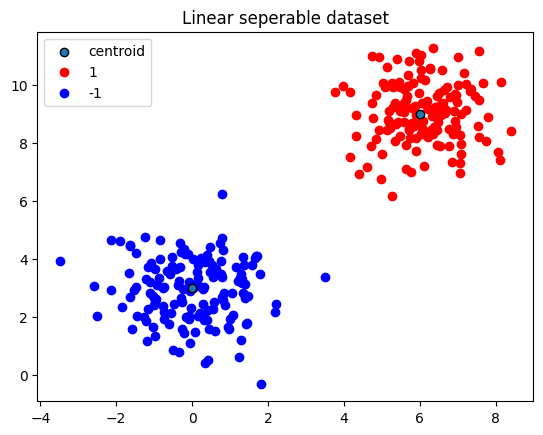

In [ ]:
#@title Generate data {vertical-output: true}
fig, ax = plt.subplots()
X, y = generate_data(300, ax=ax)

plot(X, y, ax=ax)
plt.title("Linear seperable dataset")
plt.legend();

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size=0.20,
                                       random_state=23)

We will use the `cvxopt` library to solve the SVM problem.

Let us first review the standard form of a QP (following CVXOPT notation):
\begin{equation*}
\begin{array}{ll@{}ll}
\text{minimize}  & \displaystyle \frac{1}{2} x^T Px+ q^T x\\
\text{subject to}& Gx \preceq h \\
& Ax=b
\end{array}
\end{equation*}
for more information, see this [link](https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf).

In [ ]:
from cvxopt import matrix, solvers

P = np.diag(y_train).T @ X_train @ X_train.T @ np.diag(y_train)
q = -np.ones((X_train.shape[0], ))
G = -np.eye(X_train.shape[0])
h = np.zeros_like(q)
A = np.expand_dims(y_train, 0)
b = [[0]]

sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A, tc='d'), matrix(b, tc='d'))

     pcost       dcost       gap    pres   dres
 0: -1.2053e+01 -2.0355e+01  6e+02  2e+01  2e+00
 1: -9.6364e+00 -1.3111e+00  4e+01  2e+00  1e-01
 2: -5.0315e-01 -2.2624e-01  9e-01  4e-02  3e-03
 3: -1.9486e-01 -2.1290e-01  2e-02  1e-16  1e-14
 4: -2.0864e-01 -2.0894e-01  3e-04  2e-16  6e-15
 5: -2.0889e-01 -2.0889e-01  3e-06  6e-17  6e-15
 6: -2.0889e-01 -2.0889e-01  3e-08  7e-17  6e-15
Optimal solution found.


w: [[0.47025575]
 [0.44344641]]
b: -4.143536081865783


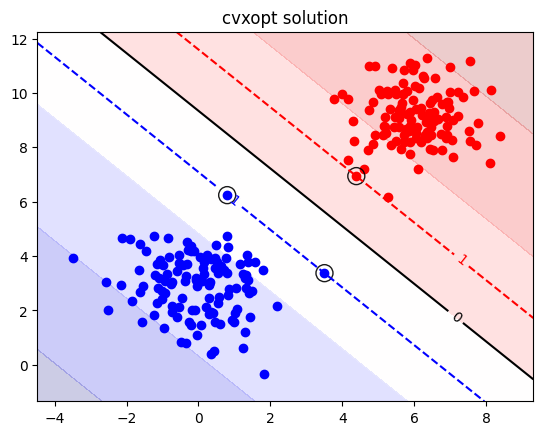

In [ ]:
#@title Recover $w$ and $b$ and plot results {vertical-output: true}
l = np.array(sol['x'])
w = X_train.T @ np.diag(y_train) @ l

support_set = (l > 1e-6).squeeze()
X_support = X_train[support_set]
y_support = y_train[support_set]

b = np.mean(y_support - X_support @ w)

def pred_fnc(X):
    return X @ w + b

plot(X_train, y_train, support=X_support, pred_fnc=pred_fnc)
plt.title("cvxopt solution")
print("w:", w)
print("b:", b)

The found solution $\lambda$ only has two or three non-zero entries, each of which corresponds to a support vector in the above figure (this is known as complementary slackness). Thus, without saving the optimal $(w^*, b^*)$, we can instead save only these non-zero $\lambda$ and their associated datapoint for inference, this is particularly helpful with kernel methods.

w: [[0.47028285]
 [0.44330671]]
b: -4.142844004294791


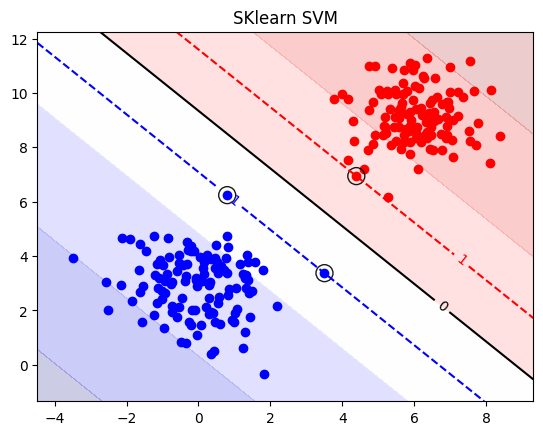

In [ ]:
#@title SVM using sklearn {vertical-output: true}
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C = 1)
clf.fit(X_train, y_train)
w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
print("w:",w_sklearn)
print("b:", b_sklearn)

plot(X_train, y_train, support=X_train[clf.support_], pred_fnc = lambda X : X @ w_sklearn + b_sklearn)
plt.title("SKlearn SVM");

## Solving hard margin SVM using projected gradient descent

The SVM problem can also be optimized using the projected gradient descent (ascent). Given a convex function $f$, at each iteration $t$, the algorithm updates the current estimated solution $x_t$ to the next $x_{t+1}$ by
$$x_{t+1} = P_C(x_t - \alpha \nabla f(x_t))$$
where $P_C$ is the projection operation onto the convex set $C$. Projected gradient method is known to converge to the optimal solution $x^* \in C$.

The gradient of the SVM problem is easy to derive, the hard part however is to compute the projection. The constraints in SVM problem is intersections of multiple convex sets, for example, in the original problem it is the intersections of half spaces, which is a polyhedron, while in the dual problem it is the intersection of a hyperplane with the positive orthant. Additionally, we can see that the projection operator in each of the individual
aforementioned set is easy to compute; the projection of a point onto a hyperplane is derived at the begining of this notebook, and the projection of a point onto the positive orthant is $P_{\mathbb R ^ n_{+}}(x) = [x]_+$, which is essientially an elemenwise clipping at zeros. Now the question is how to leverage the easy-to-compute projections in each set to compute the projection of the intersection of all the sets. The method to compute the projection we will use is described in *A Method for Finding Projections onto the Intersection of Convex Sets in Hilbert Spaces.* by Boyle, J. P., and Dykstra, R. L. in 1986.

In this section, we will use projected gradient descent to solve the dual problem of hard-margin SVM. This is not computationally efficient and thus is not used in practice.



In [ ]:
#@title The projection function
def project(l, y, iter: int=100):
    I = np.zeros((2, *l.shape))
    for _ in range(iter):
        # projection onto hyperplane y
        l -= I[0]
        proj = l - y.T @ l * y / np.sum(y * y)
        I[0] = proj - l
        l = proj

        # projection onto positive orthant
        l -= I[1]
        proj = np.maximum(0, l)
        I[1] = proj - l
        l = proj

        if np.max(np.abs(I)) < 1e-6:
            break
    return l

[0.66666667 0.66666667 1.33333333]
[0.66666667 0.66666667 1.33333333]


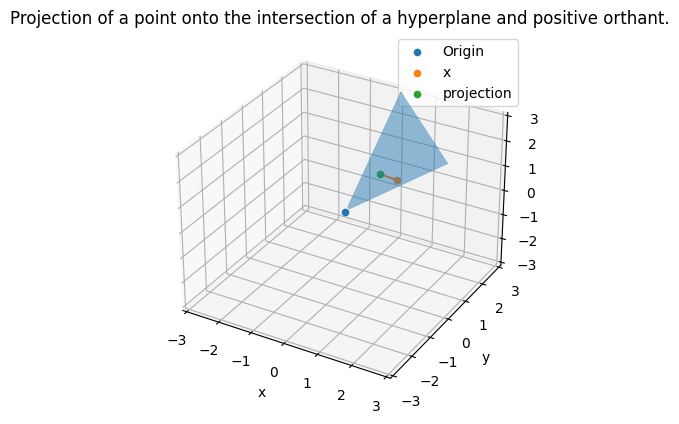

In [ ]:
#@title Testing projection function {vertical-output: true}
x = np.ones(3)
w = np.ones(3)
w[-1] = -1

print(x - (w.T@x) * w / np.sum(w*w))

proj = project(x, w, 100)
print(proj)

# plot results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xx, yy = np.array(np.meshgrid(np.arange(-3, 3, 0.01), np.arange(-3, 3, 0.01)))
zz = -(xx * w[0] + yy * w[1]) / w[2]
zz[((xx < 0) + (yy < 0) + (zz < 0)).astype(bool)] = np.nan
zz[((zz < -3) + (zz > 3)).astype(bool)] = np.nan
ax.plot_surface(xx, yy, zz, alpha=0.5)
ax.scatter(0, 0, 0, label="Origin")
ax.scatter(*x, label="x")
ax.scatter(*proj, label="projection")
ax.plot(*zip(x, proj))
plt.legend()
plt.title("Projection of a point onto the intersection of a hyperplane and positive orthant.");
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-3,3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

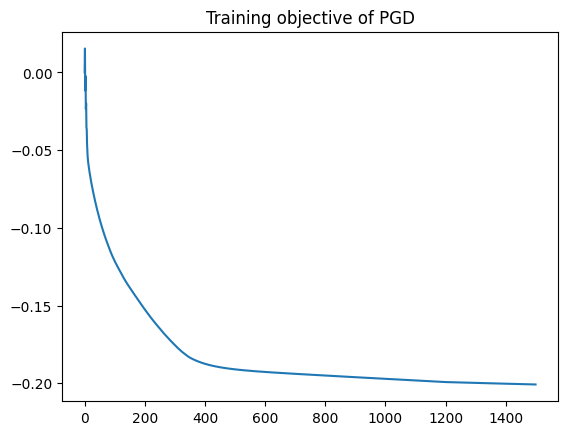

In [ ]:
#@title Training with PGD {vertical-output: true}

lr = 5e-4
epoch = 1500
losses = []

cur_lambda = np.zeros(X_train.shape[0])

for _ in range(epoch):
    loss = 0.5 * cur_lambda.T @ P @ cur_lambda + q.T @ cur_lambda
    losses.append(loss)

    grad = P @ cur_lambda + q
    cur_lambda -= lr * grad
    cur_lambda = project(cur_lambda, y_train, 300)

plt.plot(losses)
plt.title("Training objective of PGD")
plt.show();

w: [0.45471824 0.42150075]
b: -3.9989863098289478


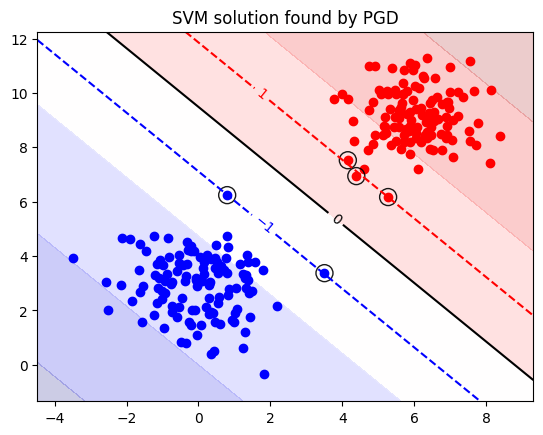

In [ ]:
#@title Solution found by PGD {vertical-output: true}
w = X_train.T @ np.diag(y_train) @ cur_lambda

support_set = (cur_lambda > 1e-4).squeeze()
X_support = X_train[support_set]
y_support = y_train[support_set]

b = np.mean(y_support - X_support @ w)

def pred_fnc(X):
    return X @ w + b

plot(X_train, y_train, support=X_support, pred_fnc=pred_fnc)
plt.title("SVM solution found by PGD")
print("w:", w)
print("b:", b)

# Soft margin SVM

The linear seperability assumption can be relaxed by introducing the slack variables $\xi_i \geq 0$, and replacing the hard margin constraints $y_i(\langle w, x_i \rangle + b) \geq 1$ with the constraints $y_i(\langle w, x_i \rangle + b) \geq 1 - \xi_i$. The problem formulation of soft SVM
\begin{equation*}
\begin{array}{ll@{}ll}
\text{minimize}  & \displaystyle \frac{1}{2}\|w\|^2 + C\sum_i \xi_i\\
\text{subject to}& \displaystyle y_i(\langle w, x_i \rangle + b) \geq 1 - \xi_i, \forall i \\
& \xi_i \geq 0 , \forall i
\end{array}
\end{equation*}
with the constant $C$ trading off between two terms. Lagrange multiplier with $\lambda$ and $\mu$
$$g(\lambda, \mu) = \min_{w, b, \xi}\frac{1}{2}\|w\|^2 + C\sum_i \xi_i + \sum_i \lambda_i [1-\xi_i - y_i(\langle w, x_i \rangle + b)] - \sum_i\mu_i\xi_i $$
\begin{align}
\Rightarrow
\begin{cases}
&w = \sum_i \lambda_i x_i y_i \\
&0=\sum_i \lambda_i y_i \\
&C =  \mu_i + \lambda_i
\end{cases}
\end{align}
substitute these again back into $g(\lambda, \mu)$, the dual problem of soft margin SVM is
\begin{equation*}
\begin{array}{ll@{}ll}
\text{maximize}  & \displaystyle \sum_i \lambda_i - \frac{1}{2}\Big\| \sum_i \lambda_i y_i x_i \Big\|^2\\
\text{subject to}& 0=\sum_i \lambda_i y_i \\
& 0 \leq \lambda_i \leq C , \forall i
\end{array}
\end{equation*}

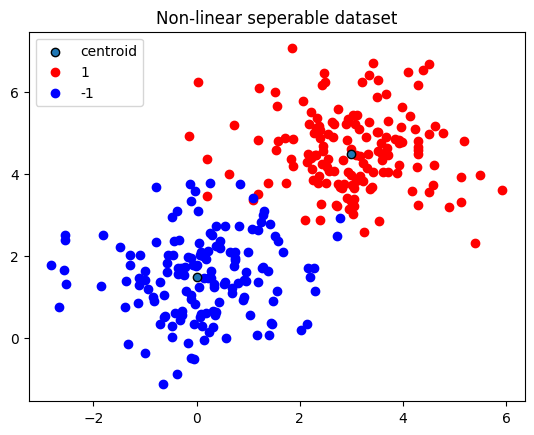

In [ ]:
#@title Generate data {vertical-output: true}
fig, ax = plt.subplots()
X, y = generate_data(300, ax=ax, linear_seperable=False)

plot(X, y, ax=ax)
plt.title("Non-linear seperable dataset")
plt.legend();

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size=0.20,
                                       random_state=23)

In [ ]:
from cvxopt import matrix, solvers

C = 1

P = np.diag(y_train).T @ X_train @ X_train.T @ np.diag(y_train)
q = -np.ones((X_train.shape[0], ))
G = np.concatenate([-np.eye(X_train.shape[0]), np.eye(X_train.shape[0])], axis=0)
h = np.zeros((X_train.shape[0]*2, ))
h[X_train.shape[0]:] = C
A = np.expand_dims(y_train, 0)
b = [[0]]

sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A, tc='d'), matrix(b, tc='d'))

     pcost       dcost       gap    pres   dres
 0: -4.4293e+01 -4.8791e+02  3e+03  3e+00  4e-14
 1: -2.7342e+01 -2.6975e+02  4e+02  3e-01  3e-14
 2: -1.5313e+01 -5.2991e+01  6e+01  4e-02  2e-14
 3: -1.1508e+01 -2.0185e+01  1e+01  9e-03  2e-14
 4: -1.1221e+01 -1.3471e+01  3e+00  2e-03  1e-14
 5: -1.1270e+01 -1.1488e+01  3e-01  1e-04  2e-14
 6: -1.1311e+01 -1.1320e+01  1e-02  3e-06  2e-14
 7: -1.1314e+01 -1.1314e+01  1e-04  3e-08  2e-14
 8: -1.1314e+01 -1.1314e+01  1e-06  3e-10  2e-14
Optimal solution found.


w: [[1.06290025]
 [1.81932275]]
b: -7.201202134858926


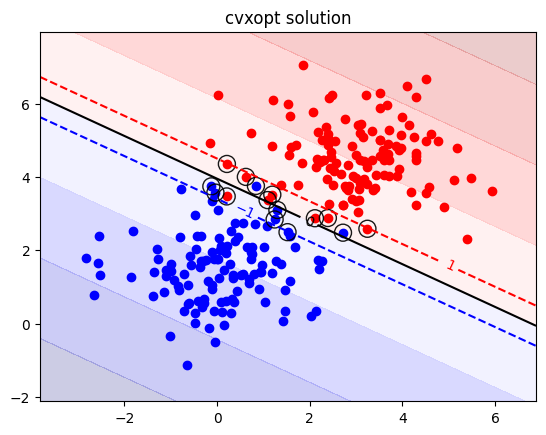

In [ ]:
#@title Recover $w$ and $b$ and plot results {vertical-output: true}
l = np.array(sol['x'])
w = X_train.T @ np.diag(y_train) @ l

# find lambdas satisfy: 0 < lambda < C
support_set = ((l < C) * (l > 1e-6)).squeeze().astype(bool)
X_support = X_train[support_set]
y_support = y_train[support_set]

b = np.mean(y_support - X_support @ w)

def pred_fnc(X):
    return X @ w + b

plot(X_train, y_train, support=X_support, pred_fnc=pred_fnc)
plt.title("cvxopt solution")
print("w:", w)
print("b:", b)

Soft margin SVM constrained problem can be transformed into non-constrained one by noticing that, in the constraints, we have a lower-bound on each $\xi_i$ as
$$\xi_i \geq 1-y_i(\langle w, x_i\rangle + b)$$
while in the objective function, we want to minize $\xi$
\begin{equation*}
\begin{array}{ll@{}ll}
\text{minimize}  & \displaystyle \frac{1}{2}\|w\|^2 + C\sum_i \xi_i
\end{array}
\end{equation*}
so each $\xi_i$ should be as low as possible, i.e. we should replace $\xi_i = \max(0, 1-y_i(\langle w, x_i\rangle + b))$, the values are capped at 0 since each $\xi_i$ is not allowed to be below 0. Now the objective becomes
$$L = \min_w \Big( \frac{1}{2}\|w\|^2 + C\sum_i \max(0, 1-y_i(\langle w, x_i\rangle + b)) \Big)$$
which is an unconstrained optimization problem and can be solve by vanilla gradient descent, the gradient is easy to derive
$$\nabla_w L = w - C X_I^T y_I  $$
$$\frac{\partial L}{\partial b}=-C 1^T y_I$$
where $I$ is the set of entries where $1-y_j(\langle w, x_j\rangle + b) > 0, \forall j \in I$. At the end of the training cycles, $I$ corresponds to the support set.

Final loss: 11.346182780749688


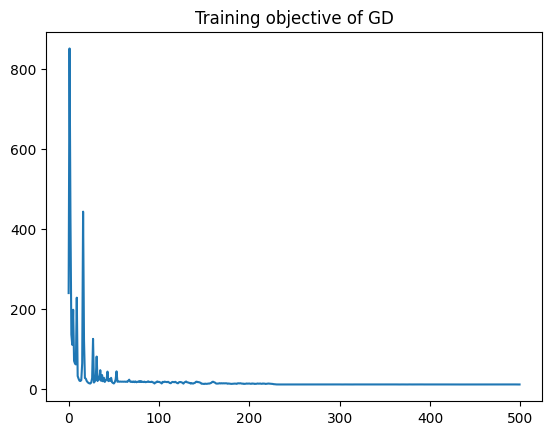

In [ ]:
#@title Solving soft margin SVM with gradient descent {vertical-output: true}

lr = 1e-2
epoch = 500
losses = []

cur_w = np.zeros((X_train.shape[1]))
cur_b = 0
I = None  # this is the support set

for _ in range(epoch):
    lr *= 1-1e-4  # some anealing lr
    loss = 0.5 * np.sum(cur_w*cur_w) + \
        C*np.sum(np.maximum(0, 1 - y_train * (X_train @ cur_w + cur_b) ))
    losses.append(loss)

    I = (y_train * (X_train @ cur_w + cur_b)) <= 1

    grad_w = cur_w - C * X_train[I].T @ y_train[I]
    cur_w -= lr * grad_w

    grad_b = -C*np.sum(y_train[I])
    cur_b -= lr * grad_b

print('Final loss:', losses[-1])
plt.plot(losses)
plt.title("Training objective of GD")
plt.show();

w: [1.11061555 1.82501946]
b: -7.342812956388384


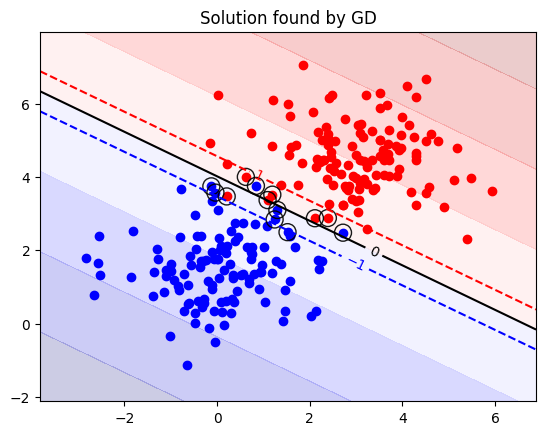

In [ ]:
#@title plot solution by GD {vertical-output: true}
def pred_fnc(X):
    return X @ cur_w + cur_b

plot(X_train, y_train, support=X_train[I], pred_fnc=pred_fnc)
plt.title("Solution found by GD")
print("w:", cur_w)
print("b:", cur_b)

w: [[1.06243988]
 [1.81853403]]
b: -7.155293218678568


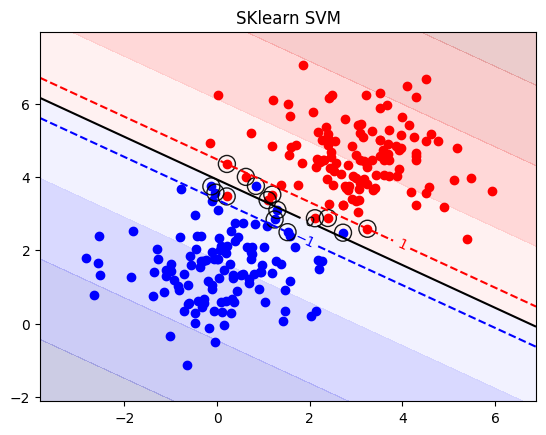

In [ ]:
#@title SVM using sklearn {vertical-output: true}
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C = C)
clf.fit(X_train, y_train)
w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
print("w:",w_sklearn)
print("b:", b_sklearn)

plot(X_train, y_train, support=X_train[clf.support_], pred_fnc = lambda X : X @ w_sklearn + b_sklearn)
plt.title("SKlearn SVM");

# Kernel SVM

Vanilla SVM only learns harlfspaces (linear model) and thus of limited usage. As such, talking about SVM without kernel trick is a missing. In kernel methods, the input is firstly mapped into a higher dimensional feature space where the data can be learned by linear models.

In SVM, we can solve the dual problem where instead of finding the actual optimal linear weight $w^*$, we seek the optimal Lagrange multipler $\lambda$. However, whether we need to recover $w^*$ is not relevant afterward. Because to do inference, one only need to check the sign of the function
$$\langle w^*, x\rangle + b^* = \sum_{i}\lambda_i \langle x_i, x\rangle + y_s - \sum_{i}\lambda_i \langle x_i, x_s\rangle$$
where $s$ is any datapoint in the support vectors set. That is, we only need to know the dot product of any two datapoint on that feature space, but not necessary the mapped data itself. Similarly, in the training phase, the optimization problem does not need to know the actual datapoints, only their dot products (see the original and dual formulation above). This is the core idea of kernel method: it allows us to learn from a higher dimensional feature space, without ever explicitly touching the data in that space.

Denote the kernel function $K(x, x')=\langle \phi(x), \phi(x')\rangle$ and the matrix $G_{ij}=K(x_i, x_j)$, the matrix $G$ is called the Gram matrix and is all we need to know to solve Kernel SVM.

     pcost       dcost       gap    pres   dres
 0: -2.3058e+01 -2.0341e+02  8e+02  2e+00  8e-16
 1: -1.5785e+01 -1.1729e+02  1e+02  7e-16  8e-16
 2: -2.0294e+01 -3.7399e+01  2e+01  5e-16  7e-16
 3: -2.3716e+01 -2.8605e+01  5e+00  2e-16  6e-16
 4: -2.4760e+01 -2.6044e+01  1e+00  3e-16  7e-16
 5: -2.5142e+01 -2.5355e+01  2e-01  1e-15  7e-16
 6: -2.5208e+01 -2.5251e+01  4e-02  1e-15  8e-16
 7: -2.5223e+01 -2.5226e+01  3e-03  7e-16  9e-16
 8: -2.5225e+01 -2.5225e+01  7e-05  1e-15  8e-16
 9: -2.5225e+01 -2.5225e+01  1e-06  2e-16  8e-16
Optimal solution found.


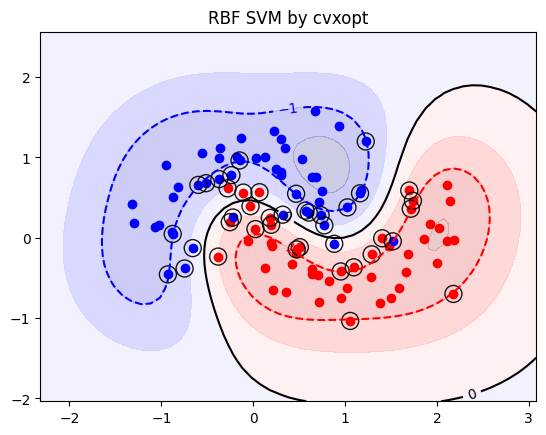

In [ ]:
#@title RBF kernel SVM {vertical-output: true}

from sklearn.datasets import make_moons
import gc

X, y = make_moons(noise=0.3, random_state=0)
y[y==0] = -1
C=1

# RBF kernel
def gram_matrix(X):
    X_minus_X = np.expand_dims(X, 0) - np.expand_dims(X, 1)
    X_minus_X_norm = (X_minus_X ** 2).sum(axis=-1)
    G = np.exp(-X_minus_X_norm)
    return G

G = gram_matrix(X)
P = np.diag(y).T @ G @ np.diag(y)
q = -np.ones((X.shape[0], ))
G = np.concatenate([-np.eye(X.shape[0]), np.eye(X.shape[0])], axis=0)
h = np.zeros((X.shape[0]*2, ))
h[X.shape[0]:] = C
A = np.expand_dims(y, 0)
b = [[0]]

sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A, tc='d'), matrix(b, tc='d'))
l = np.array(sol['x']).squeeze()

support_set = l > 1e-6
X_sup = X[support_set]
y_sup = y[support_set]
l_sup = l[support_set]

b = np.mean(y_sup - \
            l_sup @ np.diag(y_sup) @ \
            gram_matrix(X_sup))

gc.collect()

def pred(X_train):
    G = np.exp(-((np.expand_dims(X_train, 0) - np.expand_dims(X_sup, 1)) ** 2).sum(axis=-1))
    ret = l_sup @ np.diag(y_sup) @ G + b
    return ret

plot(X, y, support=X_sup, pred_fnc = pred)
plt.title("RBF SVM by cvxopt");

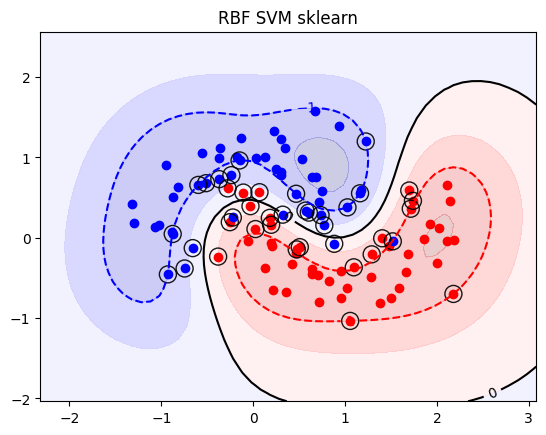

In [ ]:
#@title kernel SVM Sklearn {vertical-output: true}
clf = SVC(kernel="rbf", C=C, gamma=1, shrinking=False)
clf.fit(X, y)

plot(X, y, support=X[clf.support_], pred_fnc=clf.decision_function)
plt.title("RBF SVM sklearn");

What is so important about kernel SVM? There exists some kernel function that are very easy to compute, but the actual inner product that makes that kernel happens actually resides in very high dimensional, even infinite spaces. RBF kernek is one example where the actual inner product space is infinite. In such spaces, managing the weight vector $w$ becomes impossible, as $w$ has the same dimensions as the data, which can be infinite in size. ***The kernel tricks with dual SVM allow us to learn models in such infinite spaces with finite resources***; we only need to keep the Lagrange multiplier $\lambda$ where they are active (on the support set, which is usually small compared to the entire dataset) and their associated (original) datapoints.

As a side note, to see why RBF kernel is an inner product in an infinite dimensional space, observe that
\begin{align}
e^{-\frac{\|x-y\|^2}{2}} &= e^{-\frac{1}{2}\langle x-y, x-y \rangle} = e^{-\frac{1}{2}(\|x\|^2 + \|y\|^2 - 2\langle x, y \rangle)}\\
&=  e^{-\frac{1}{2}(\|x\|^2 + \|y\|^2)}e^{\langle x, y \rangle} =  e^{-\frac{1}{2}(\|x\|^2 + \|y\|^2)}e^{\sum_ix_iy_i} \\
&= e^{-\frac{1}{2}(\|x\|^2 + \|y\|^2)}\prod_i e^{x_iy_i}\\
&= e^{-\frac{1}{2}(\|x\|^2 + \|y\|^2)}\prod_i \sum_{j=0}^\infty \frac{(x_iy_i)^j}{j!}\\
&= \sum_{j=0}^\infty e^{-\frac{1}{2}\|x\|^2}e^{-\frac{1}{2}\|y\|^2}\prod_i \frac{(x_iy_i)^j}{j!}\\
&= \Big\langle e^{-\frac{1}{2}\|x\|^2}\Big(1, \prod_i \frac{x_i}{1}, \prod_i \frac{x_i^2}{\sqrt{2!}}, \dots \Big), e^{-\frac{1}{2}\|y\|^2}\Big(1, \prod_i \frac{y_i}{1}, \prod_i \frac{y_i^2}{\sqrt{2!}}, \dots \Big) \Big\rangle
\end{align}
here we use Taylor series to expand the term $e^{x_iy_i}$.

SVM on infinite dimensional spaces introduces another interesting observation. We know from statistical learning theory that the VC dimension of halfspace in $\mathbb R^n$ is $n+1$, so SVM on inifinte space can have infinite VC dimension, which means that it can shatter all datasets of any finite sizes. This is essentially saying that kernel SVM can theoretically achieve zero loss on any training set.

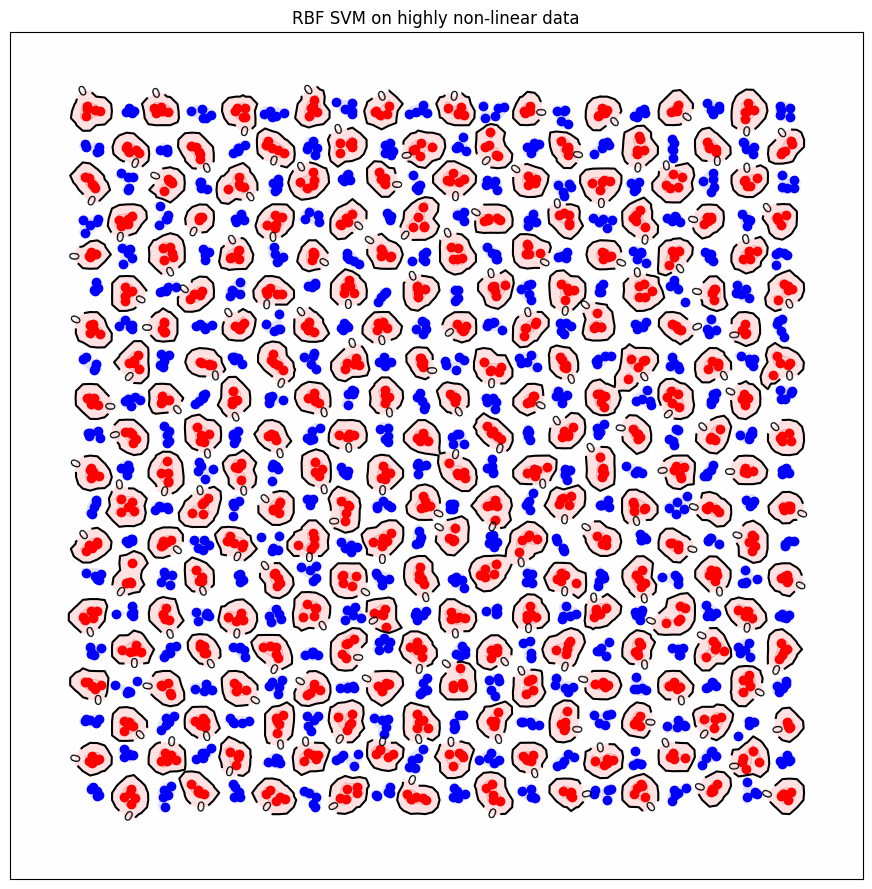

In [ ]:
#@title The infinite capacity SVM  {vertical-output: true}

coord = [np.arange(-5, 5, 0.5) for _ in range(2)]
mesh = np.array(np.meshgrid(*coord))
X = mesh.reshape(mesh.shape[0], -1).T
y = (np.indices((int(np.sqrt(X.shape[0])),)*2).sum(axis=0) % 2).reshape(-1)
y[y==0] = -1

n_each_cluster = 5
X = np.repeat(X, n_each_cluster, axis=0)
X = X + np.random.randn(*X.shape) / 15
y = np.repeat(y, n_each_cluster)

clf = SVC(kernel="rbf", C=1, gamma=200)
clf.fit(X, y)

fig, ax = plt.subplots(figsize=(11, 11))
plt.xticks([])
plt.yticks([])
plot(X, y, pred_fnc=clf.decision_function, ax=ax)
plt.title("RBF SVM on highly non-linear data");

The above example illustrates the power of kernel SVM. This might come as a surprise, because many belive that SVM is a simple model that cannot compare to complex, highly non-linear models such as neural networks (imagine how big it is for a neural network to learn such a complex pattern). And this all happens by a linear model learning on some other high dimensional spaces. The final question is whether  SVM can overfit in infinite dimensional spaces. Learning theory says that models with infinite VC dimensions are not PAC learnability. Several theories have been used to explain this. In short, the learnability of SVM depends on the margin and not the dimension of the data.